In [296]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data

We selected ~200 patients who have been enrolled in the program for 3 to 11 months and
included all their blood pressure and blood glucose readings and organized by time stamp.

I attached the de-identified dataset:
* The first dataset &quot;Health_Sample dataset_SBP by month.xlsx&quot; contains all monthly
average Systolic BP readings of each patient with a timestamp.
* The second dataset “iHealth Time Series - v1” contains all the original data.

In [345]:
sbp = pd.read_excel('data/SBP_by_month.xlsx')
# drop unnamed column
sbp.pop('Unnamed: 0')
print(sbp.shape)
sbp.head()

# “Normal” “Elevated” and “High Blood Pressure Stage 1” are considered “Controlled”
# “Hypertension Stage 2” and “Hypertensive Crisis” are considered “Uncontrolled”
# Looking at the chart, controlled simply corresponds to a systolic blood pressure of 140 or less.
sbp['controlled'] = sbp['systolic_mmHg'] < 140

# Reindex months
first_month = sbp.groupby('memberId')['month'].min().rename('first_month')
sbp = sbp.join(first_month, on='memberId')
sbp['months'] = sbp['month'].dt.to_period('m').astype(int) - sbp['first_month'].dt.to_period('m').astype(int)
print(sbp.shape)

# Whether the member was controlled at baseline
tmp = sbp.loc[sbp.months == 0, ['memberId', 'controlled']]
tmp.rename({'controlled': 'ctrl_bl'}, axis=1, inplace=True)
tmp.set_index('memberId', inplace=True)
sbp = sbp.join(tmp, on='memberId')
print(sbp.shape)

(1203, 3)
(1203, 6)
(1203, 7)


In [11]:
ts = pd.read_excel('data/time_series.xlsx')
print(ts.shape)
ts.head()

(33125, 21)


,memberId,Enrolled Tasks,age_range,Gender,Is Still Enrolled,datetime_utc,timezone_local,date_local,type,took_medication,...,datetime_local,arrhythmic,systolic BP_mmHg,diastolic BP_mmHg,heart_rate_bp,bg_mmol,meal_type,before_meal,body_weight,weight_change_kg
0,62a260c03b64e85e96af1d1f,"BP, HS",70-74,F,0,NaT,NaN,NaT,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,62a260c03b64e85e96af1d20,"BP, HS",45-49,M,1,2022-07-24 01:22:43,America/Los_Angeles,2022-07-23,BP,1.0,...,2022-07-23 18:22:43,0.0,129.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN
2,62a260c03b64e85e96af1d20,"BP, HS",45-49,M,1,2022-07-24 01:37:00,America/Los_Angeles,2022-07-23,BP,1.0,...,2022-07-23 18:37:00,0.0,123.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN
3,62a260c03b64e85e96af1d20,"BP, HS",45-49,M,1,2022-07-24 15:58:59,America/Los_Angeles,2022-07-24,BP,1.0,...,2022-07-24 08:58:59,0.0,131.0,97.0,NaN,NaN,NaN,NaN,NaN,NaN
4,62a260c03b64e85e96af1d20,"BP, HS",45-49,M,1,2022-07-25 05:58:04,America/Los_Angeles,2022-07-24,BP,1.0,...,2022-07-24 22:58:04,0.0,135.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
print(ts.columns)

Index(['memberId', 'Enrolled Tasks', 'age_range', 'Gender',
       'Is Still Enrolled', 'datetime_utc', 'timezone_local', 'date_local',
       'type', 'took_medication', 'measurement_id', 'datetime_local',
       'arrhythmic', 'systolic BP_mmHg', 'diastolic BP_mmHg', 'heart_rate_bp',
       'bg_mmol', 'meal_type', 'before_meal', 'body_weight',
       'weight_change_kg'],
      dtype='object')


In [9]:
sbp.describe(include='all')

,memberId,month,systolic_mmHg
count,1203,1203,1203.000000
unique,246,NaN,NaN
top,62a260c03b64e85e96af1d20,NaN,NaN
freq,11,NaN,NaN
mean,NaN,2023-01-01 15:58:48.179550976,137.421596
min,NaN,2022-06-01 00:00:00,98.000000
25%,NaN,2022-11-01 00:00:00,125.915000
50%,NaN,2023-01-01 00:00:00,137.000000
75%,NaN,2023-03-01 00:00:00,147.470000
max,NaN,2023-05-01 00:00:00,189.000000


In [10]:
ts.describe(include='all')

,memberId,Enrolled Tasks,age_range,Gender,Is Still Enrolled,datetime_utc,timezone_local,date_local,type,took_medication,...,datetime_local,arrhythmic,systolic BP_mmHg,diastolic BP_mmHg,heart_rate_bp,bg_mmol,meal_type,before_meal,body_weight,weight_change_kg
count,33125,33125,33125,33125,33125.000000,33067,33067,33067,33067,32450.000000,...,33067,22514.000000,22514.000000,22514.000000,0.0,9936.000000,9936,9936.000000,0.0,617.000000
unique,341,10,14,2,NaN,NaN,15,NaN,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN
top,6361bdcc02701b7b6da0e269,"BP, HS",60-64,M,NaN,NaN,America/Los_Angeles,NaN,BP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,BREAKFAST,NaN,NaN,NaN
freq,930,15219,6678,19837,NaN,NaN,31304,NaN,22514,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5853,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,0.923925,2023-01-30 06:50:35.420479744,NaN,2023-01-29 11:09:35.595004160,NaN,0.487858,...,2023-01-29 23:29:09.340702208,0.077907,135.610642,80.177223,NaN,8.323951,NaN,0.655998,NaN,0.007796
min,NaN,NaN,NaN,NaN,0.000000,2019-01-01 00:16:56,NaN,2018-12-31 00:00:00,NaN,0.000000,...,2018-12-31 16:16:56,0.000000,37.000000,30.000000,NaN,1.111111,NaN,0.000000,NaN,-103.370000
25%,NaN,NaN,NaN,NaN,1.000000,2022-11-30 15:16:13.500000,NaN,2022-11-30 00:00:00,NaN,0.000000,...,2022-11-30 07:36:55,0.000000,122.000000,72.000000,NaN,6.277778,NaN,0.000000,NaN,-11.540000
50%,NaN,NaN,NaN,NaN,1.000000,2023-02-09 15:26:14,NaN,2023-02-09 00:00:00,NaN,0.000000,...,2023-02-09 07:26:14,0.000000,135.000000,80.000000,NaN,7.666667,NaN,1.000000,NaN,0.000000
75%,NaN,NaN,NaN,NaN,1.000000,2023-04-11 14:27:49,NaN,2023-04-11 00:00:00,NaN,1.000000,...,2023-04-11 07:27:49,0.000000,148.000000,88.000000,NaN,9.666667,NaN,1.000000,NaN,12.040000
max,NaN,NaN,NaN,NaN,1.000000,2023-06-01 13:39:42,NaN,2023-06-01 00:00:00,NaN,1.000000,...,2023-06-01 06:39:42,1.000000,280.000000,181.000000,NaN,30.666667,NaN,1.000000,NaN,71.500000


In [16]:
ts.measurement_id.describe()

count                        33067
unique                       32341
top       64114a819d325900133b27d8
freq                             2
Name: measurement_id, dtype: object

# Data Quality

### Patient Sampling

Of the 341 members in the full dataset, 246 of them were sampled for the SBP monthly dataset.

In [72]:
print(sbp.memberId.nunique())
print(ts.memberId.nunique())

246
341


### Duplicate & Missing Measurements
Why are there non-unique and missing `measurement_id`s?

There are 5 members in the SBP dataset with duplicate measurements in the full dataset. For simplicity, we will likely end up excluding these members in future analysis.

In [48]:
vc = ts.measurement_id.value_counts(dropna=False)
vc

measurement_id
NaN                         58
63994735af5b37001341ba5a     2
639018fe64288f0014b8fd9e     2
6390b08bfa0ecf00135c6253     2
63916f7e8c25ca0013526634     2
                            ..
640e61af41f44100135257ab     1
640e5eb79dee710013e89a72     1
640e5dd563cabb0013e406c7     1
640e5d3c3b852b00144eb386     1
647649cc3e08d7001329c5cf     1
Name: count, Length: 32342, dtype: int64

In [23]:
ts[ts.measurement_id.isnull()].isnull().mean()

memberId             0.0
Enrolled Tasks       0.0
age_range            0.0
Gender               0.0
Is Still Enrolled    0.0
datetime_utc         1.0
timezone_local       1.0
date_local           1.0
type                 1.0
took_medication      1.0
measurement_id       1.0
datetime_local       1.0
arrhythmic           1.0
systolic BP_mmHg     1.0
diastolic BP_mmHg    1.0
heart_rate_bp        1.0
bg_mmol              1.0
meal_type            1.0
before_meal          1.0
body_weight          1.0
weight_change_kg     1.0
dtype: float64

Where the `measurement_id` is null, there are no observations beyond attributes of the patient.

In [67]:
dupe_measurements = vc[vc > 1].index.dropna()
candidate_dupes = ts[ts.measurement_id.isin(dupe_measurements)]
# candidate_dupes.pop('Enrolled Tasks')
print(candidate_dupes.shape)
# candidate_dupes.drop_duplicates(inplace=True)
# print(candidate_dupes.shape)

(1452, 21)


In [68]:
candidate_dupes.memberId.nunique()

5

In [70]:
candidate_dupes.memberId.isin(sbp.memberId).any()

True

### Verify Monthly Avg
I'm not able to exactly replicate the calculated monthly average in the SBP dataset, but it is very close for the vast majority of members.

In [77]:
sbp.set_index(['memberId', 'month'], inplace=True)
sbp.head()

systolic_mmHg
memberId                 month                    
62a260c03b64e85e96af1d20 2022-07-01         133.08
                         2022-08-01         131.00
                         2022-09-01         130.88
                         2022-10-01         132.91
                         2022-11-01         127.75

In [176]:
months = ts['datetime_utc'].dt.to_period('m').dt.to_timestamp().rename('month')
avg = ts.groupby(['memberId', months])['systolic BP_mmHg'].mean()
avg_frame = sbp.join(avg.to_frame()).rename({'systolic BP_mmHg': 'systolic_mmHgdatetime_utc'}, axis=1)

for col in ['date_local', 'datetime_local']:
    months = ts[col].dt.to_period('m').dt.to_timestamp().rename('month')
    avg = ts.groupby(['memberId', months])['systolic BP_mmHg'].mean().to_frame().rename({'systolic BP_mmHg': 'systolic_mmHg' + col}, axis=1)
    avg_frame = avg_frame.join(avg)

In [177]:
avg_frame.head()

systolic_mmHg  systolic_mmHgdatetime_utc  \
memberId                 month                                                  
62a260c03b64e85e96af1d20 2022-07-01         133.08                 133.083333   
                         2022-08-01         131.00                 131.136364   
                         2022-09-01         130.88                 130.705882   
                         2022-10-01         132.91                 132.913043   
                         2022-11-01         127.75                 127.769231   

                                     systolic_mmHgdate_local  \
memberId                 month                                 
62a260c03b64e85e96af1d20 2022-07-01               133.083333   
                         2022-08-01               131.000000   
                         2022-09-01               130.875000   
                         2022-10-01               132.913043   
                         2022-11-01               127.754717   

                                     systolic_mmHgdatetime_local  
memberId                 month                                    
62a260c03b64e85e96af1d20 2022-07-01                   133.083333  
                         2022-08-01                   131.000000  
                         2022-09-01                   130.875000  
                         2022-10-01                   132.913043  
                         2022-11-01                   127.754717

In [196]:
diffs = avg_frame.apply(lambda s: s - avg_frame['systolic_mmHg'])
diffs.describe(percentiles=[0.01, 0.99])

,systolic_mmHg,systolic_mmHgdatetime_utc,systolic_mmHgdate_local,systolic_mmHgdatetime_local
count,1203.0,1202.000000,1203.000000,1203.000000
mean,0.0,-0.000716,-0.018278,-0.018278
std,0.0,1.774804,1.526524,1.526524
min,0.0,-19.000000,-10.800000,-10.800000
1%,0.0,-5.436600,-4.770743,-4.770743
50%,0.0,0.000000,0.000000,0.000000
99%,0.0,5.245025,3.974970,3.974970
max,0.0,23.841667,23.841667,23.841667


<Axes: ylabel='Density'>

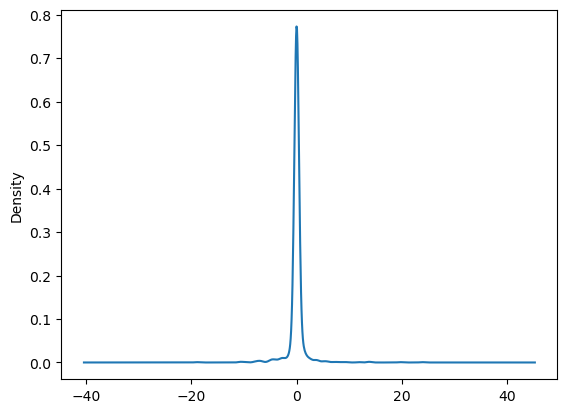

In [194]:
diffs['systolic_mmHgdatetime_utc'].plot(kind='kde')

# Data Exploration

Can you draw a figure that visualizes the SBP (systolic blood pressure) change over the months
for each patient based on the first data file? In this way, we can have an initial observation of
different blood pressure risk change patterns over time.

/Users/mac/opt/anaconda3/envs/ihealthlabs/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/opt/anaconda3/envs/ihealthlabs/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='months', ylabel='systolic_mmHg'>

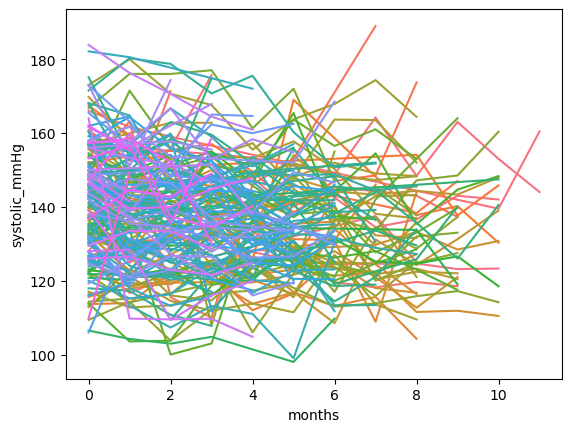

In [229]:
sns.lineplot(data=sbp, x="months", y="systolic_mmHg", hue="memberId", legend=False)
# sns.lineplot(data=sbp, x="months", y="systolic_mmHg")

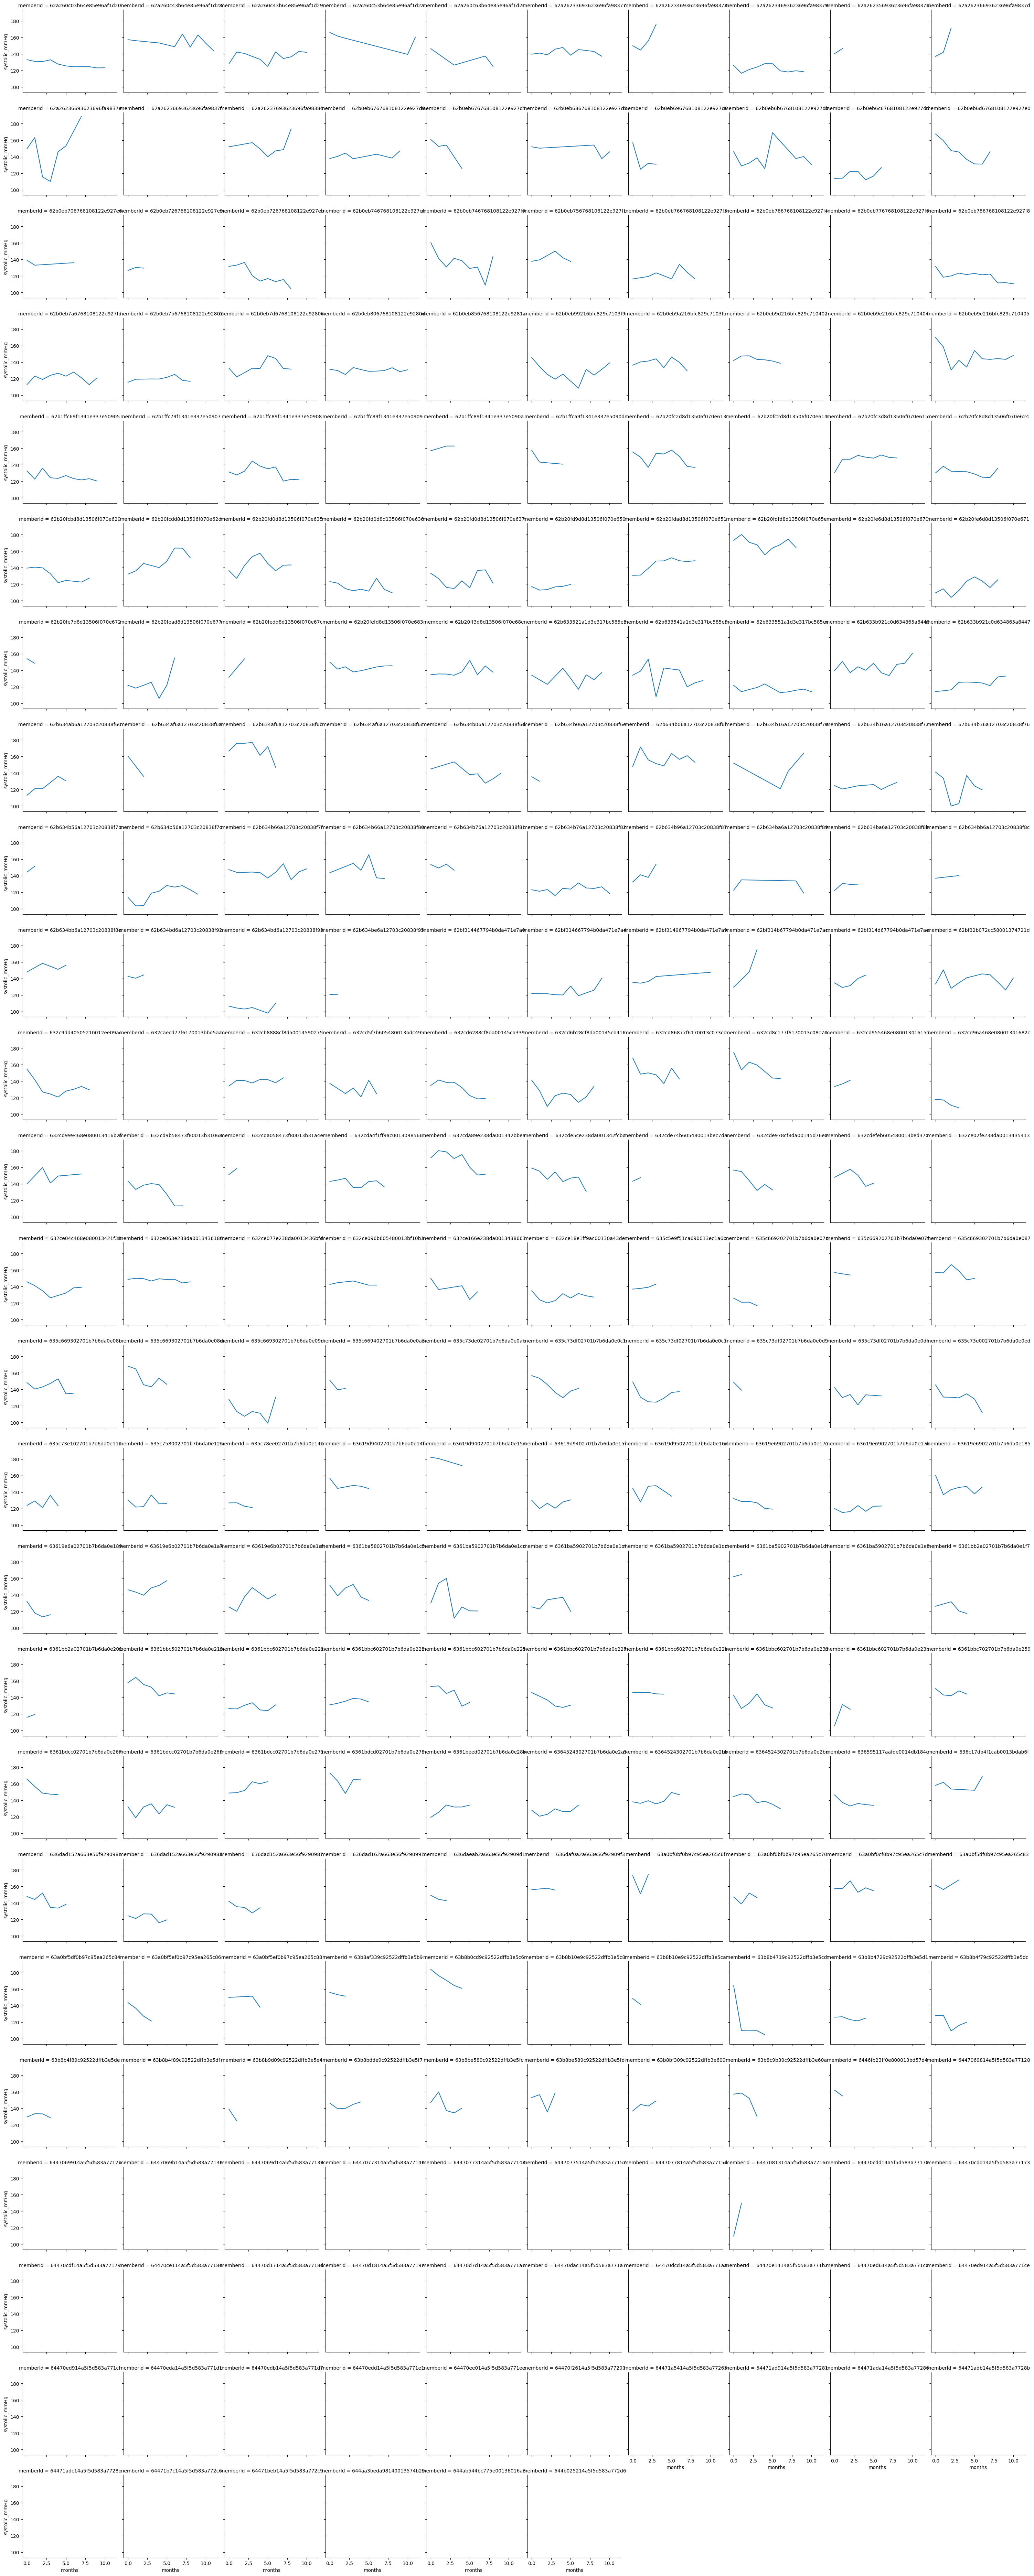

In [247]:
# weight by number of months of observations
# sample_members = sbp.memberId.sample(100).unique()
g = sns.FacetGrid(data=sbp, col='memberId', col_wrap=10)
g.map(plt.plot, 'months', 'systolic_mmHg')
plt.show()

The rather unwieldy plot above shows the time series for each member. We will do further analysis grouped by member and blood pressure factors later on.

# Questions

## 1. How many months needed for patient from uncontrolled to controlled

In [277]:
# Find first controlled month for each member uncontrolled at baseline
first_controlled = sbp[~sbp.ctrl_bl & sbp.controlled].groupby('memberId')['month'].min().rename('first_controlled')
sbp = sbp.join(first_controlled, on='memberId')

In [282]:
sbp.first_controlled.unique()

<DatetimeArray>
[                'NaT', '2023-04-01 00:00:00', '2022-10-01 00:00:00',
 '2022-08-01 00:00:00', '2022-11-01 00:00:00', '2023-01-01 00:00:00',
 '2023-05-01 00:00:00', '2022-09-01 00:00:00', '2022-12-01 00:00:00',
 '2023-03-01 00:00:00', '2023-02-01 00:00:00']
Length: 11, dtype: datetime64[ns]

In [339]:
sbp.groupby('memberId')['month'].min()

memberId
62a260c03b64e85e96af1d20   2022-07-01
62a260c43b64e85e96af1d28   2022-06-01
62a260c43b64e85e96af1d29   2022-06-01
62a260c53b64e85e96af1d2a   2022-06-01
62a260c63b64e85e96af1d2c   2022-07-01
                              ...    
64471b7c14a5f5d583a772c6   2023-05-01
64471beb14a5f5d583a772c9   2023-05-01
644aa3beda98140013574b29   2023-05-01
644ab544bc775e00136016a3   2023-05-01
644b025214a5f5d583a772d6   2023-05-01
Name: month, Length: 246, dtype: datetime64[ns]

In [298]:
members = pd.DataFrame(sbp[['memberId', 'ctrl_bl', 'first_controlled']])
members.drop_duplicates(inplace=True)
members.set_index('memberId', inplace=True)
members['first_month'] = sbp.groupby('memberId')['month'].min()

members['months_to_control'] = np.nan
members.loc[members.first_controlled.notnull(), 'months_to_control'] = members['first_controlled'].dt.to_period('m').astype(int) - members['first_month'].dt.to_period('m').astype(int)

members.head()

,ctrl_bl,first_controlled,first_month,months_to_control
memberId,,,,
62a260c03b64e85e96af1d20,True,NaT,2022-07-01,NaN
62a260c43b64e85e96af1d28,False,NaT,2022-06-01,NaN
62a260c43b64e85e96af1d29,True,NaT,2022-06-01,NaN
62a260c53b64e85e96af1d2a,False,2023-04-01,2022-06-01,10.0
62a260c63b64e85e96af1d2c,False,2022-10-01,2022-07-01,3.0


In [299]:
members.months_to_control.describe()

count    56.000000
mean      2.696429
std       2.088232
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      10.000000
Name: months_to_control, dtype: float64

/Users/mac/opt/anaconda3/envs/ihealthlabs/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='months_to_control', ylabel='Count'>

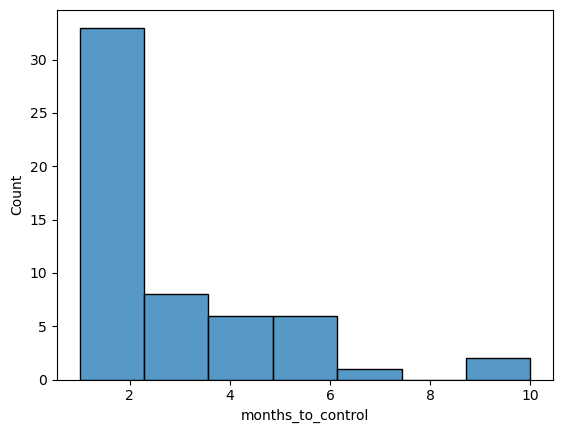

In [301]:
sns.histplot(members.months_to_control)

On average, it takes 2-3 months for members to reach a controlled state, but it can be as long as ten months.

## 2. For well controlled patients at baseline, is it well maintained?

In [338]:
sbp.loc[sbp.ctrl_bl, 'controlled'].astype(int).describe()

count    621.000000
mean       0.835749
std        0.370802
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: controlled, dtype: float64

84% of members who start controlled remain controlled for the duration of the data. Although this is a high percentage, this also means that over 15% of patients are entering uncontrolled territory within a year. This strikes me as a high rate of incidence of high blood pressure, so I'd argue that it is not consistently well-maintained by members controlled at baseline. Perhaps they are included in the data because they have risk factors for high blood pressure, which may explain why many of them enter the uncontrolled state.

## 3. For patients from uncontrolled to controlled, is it well maintained or easy to be uncontrolled again?

In [321]:
become_controlled = ~sbp.ctrl_bl & sbp.first_controlled.notnull()

member_mean = sbp.loc[become_controlled & (sbp.month > sbp.first_controlled)].groupby('memberId')['controlled'].mean()
member_mean.describe()

count    49.000000
mean      0.622230
std       0.405111
min       0.000000
25%       0.250000
50%       0.714286
75%       1.000000
max       1.000000
Name: controlled, dtype: float64

In [374]:
members['pct_controlled'] = member_mean

In [355]:
members = members.join((member_mean == 1).rename('maintained'))

In [323]:
(member_mean == 1).mean()

0.4489795918367347

In [324]:
member_mean[member_mean < 1].mean()

0.31441798941798943

Patients who achieve blood pressure control appear to be somewhat successful at maintaining it, but it is not uncommon for blood pressure to return to being uncontrolled. Although nearly half of members were controlled for the remainder of their time in the program, on average a little under two-thirds of a member's remaining time in the program was controlled. Of members who fell out of control, less than a third of their remaining time in the program was controlled.

This indicates that, although some patients are able to maintain control, those that do not tend to remain mostly uncontrolled for the time in their program. On the assumption that one is trying to build safeguards for patients trying to maintain control, it would make sense to offer special treatment to any patient who falls out of control even once.

## 4. For patients always uncontrolled, what are the vitals patterns?

In [349]:
time_controlled = sbp.groupby('memberId')['controlled'].mean()
always_uncontrolled = time_controlled[time_controlled == 0].index

In [350]:
vitals = ['arrhythmic', 'systolic BP_mmHg', 'diastolic BP_mmHg', 'heart_rate_bp', 'bg_mmol']
ts.groupby(ts.memberId.isin(always_uncontrolled))[vitals].mean()

,arrhythmic,systolic BP_mmHg,diastolic BP_mmHg,heart_rate_bp,bg_mmol
memberId,,,,,
False,0.076419,131.772398,78.916969,NaN,8.299992
True,0.085327,154.742690,86.459064,NaN,8.420958


For patients that are always uncontrolled, they tend to have slightly higher instances of arrhythmia and slightly higher blood glucose. Unsurprisingly, they have significantly higher blood pressure, both systolic and diastolic.

## 5. What’s the pattern for vital monitoring activity? Should we set up a graduation timeline?

A graduation timeline suggests seeking metrics that predict well-maintained future blood pressure.

<Axes: xlabel='months_to_control'>

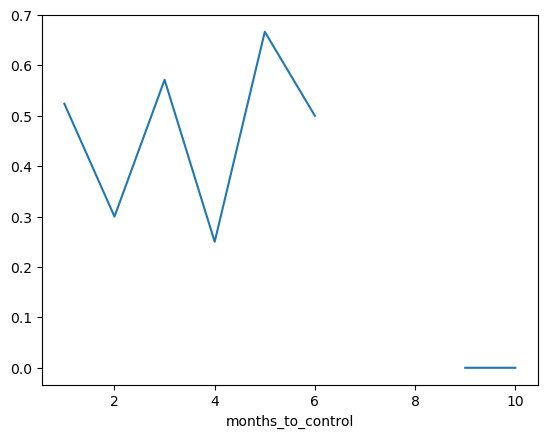

In [359]:
members.groupby('months_to_control')['maintained'].mean().plot()

A bit surprisingly, the length of time it took to achive control doesn't appear to be predictive of blood pressure control maintenance.

In [361]:
members['last_month'] = sbp.groupby('memberId')['month'].max()

In [365]:
members['program_duration'] = members.last_month.dt.to_period('m').astype(int) - members.first_month.dt.to_period('m').astype(int)

Let's examine members who achieved control within 1-2 months and were in the program for at least another six.

In [375]:
mask = (members.months_to_control <= 2) & (members.program_duration >= members.months_to_control + 6)
members[mask]

,ctrl_bl,first_controlled,first_month,months_to_control,maintained,last_month,program_duration,pct_controlled
memberId,,,,,,,,
62b0eb6b6768108122e927db,False,2022-08-01,2022-07-01,1.0,False,2023-05-01,10,0.714286
62b0eb746768108122e927f0,False,2022-11-01,2022-09-01,2.0,False,2023-05-01,8,0.666667
62b0eb99216bfc829c7103f9,False,2022-08-01,2022-07-01,1.0,True,2023-05-01,10,1.000000
62b0eb9e216bfc829c710405,False,2022-09-01,2022-07-01,2.0,False,2023-05-01,10,0.125000
62b20fc2d8d13506f070e613,False,2022-11-01,2022-09-01,2.0,False,2023-05-01,8,0.333333
632c9dd40505210012ee09ac,False,2022-11-01,2022-09-01,2.0,True,2023-05-01,8,1.000000
632cd6b28cf8da00145cb416,False,2022-10-01,2022-09-01,1.0,True,2023-05-01,8,1.000000
632cd9b58473f80013b31068,False,2022-11-01,2022-10-01,1.0,False,2023-05-01,7,0.833333


In [377]:
members

,ctrl_bl,first_controlled,first_month,months_to_control,maintained,last_month,program_duration,pct_controlled
memberId,,,,,,,,
62a260c03b64e85e96af1d20,True,NaT,2022-07-01,NaN,NaN,2023-05-01,10,NaN
62a260c43b64e85e96af1d28,False,NaT,2022-06-01,NaN,NaN,2023-05-01,11,NaN
62a260c43b64e85e96af1d29,True,NaT,2022-06-01,NaN,NaN,2023-04-01,10,NaN
62a260c53b64e85e96af1d2a,False,2023-04-01,2022-06-01,10.0,False,2023-05-01,11,0.0
62a260c63b64e85e96af1d2c,False,2022-10-01,2022-07-01,3.0,True,2023-03-01,8,1.0
...,...,...,...,...,...,...,...,...
64471b7c14a5f5d583a772c6,True,NaT,2023-05-01,NaN,NaN,2023-05-01,0,NaN
64471beb14a5f5d583a772c9,False,NaT,2023-05-01,NaN,NaN,2023-05-01,0,NaN
644aa3beda98140013574b29,False,NaT,2023-05-01,NaN,NaN,2023-05-01,0,NaN


In [382]:
sbp

,memberId,month,systolic_mmHg,controlled,first_month,months,ctrl_bl
0,62a260c03b64e85e96af1d20,2022-07-01,133.08,True,2022-07-01,0,True
1,62a260c03b64e85e96af1d20,2022-08-01,131.00,True,2022-07-01,1,True
2,62a260c03b64e85e96af1d20,2022-09-01,130.88,True,2022-07-01,2,True
3,62a260c03b64e85e96af1d20,2022-10-01,132.91,True,2022-07-01,3,True
4,62a260c03b64e85e96af1d20,2022-11-01,127.75,True,2022-07-01,4,True
...,...,...,...,...,...,...,...
1198,64471b7c14a5f5d583a772c6,2023-05-01,112.62,True,2023-05-01,0,True
1199,64471beb14a5f5d583a772c9,2023-05-01,152.14,False,2023-05-01,0,False
1200,644aa3beda98140013574b29,2023-05-01,155.50,False,2023-05-01,0,False
1201,644ab544bc775e00136016a3,2023-05-01,120.33,True,2023-05-01,0,True


In [405]:
res

,memberId,month,last_maintained,632ce166e238da0013438663
0,62a260c03b64e85e96af1d20,2022-07-01,2022-06-01,2023-04-01
1,62a260c03b64e85e96af1d20,2022-08-01,2022-07-01,2023-04-01
2,62a260c03b64e85e96af1d20,2022-09-01,2022-08-01,2023-04-01
3,62a260c03b64e85e96af1d20,2022-10-01,2022-09-01,2023-04-01
4,62a260c03b64e85e96af1d20,2022-11-01,2022-10-01,2023-04-01
...,...,...,...,...
1198,64471b7c14a5f5d583a772c6,2023-05-01,2023-04-01,2023-04-01
1199,64471beb14a5f5d583a772c9,2023-05-01,2023-04-01,2023-04-01
1200,644aa3beda98140013574b29,2023-05-01,2023-04-01,2023-04-01
1201,644ab544bc775e00136016a3,2023-05-01,2023-04-01,2023-04-01


In [425]:
cols = ['memberId', 'month', 'last_maintained']
res = pd.DataFrame(columns=cols)

for idx, r in sbp.iterrows():
    id = r.memberId
    month = r.month

    for i in range(1,11)
    
    months_prior = sbp.loc[(sbp.memberId == id) & (sbp.month < month)]
    last_maintained = months_prior.loc[months_prior.controlled, 'month'].max()
    
    res = pd.concat([res, pd.DataFrame({'memberId': id, 'month': month, 'last_maintained': last_maintained}, index=[idx])], axis=0)

res

/var/folders/1l/zdw52jqn16j9_m8_w4ppfvq40000gn/T/ipykernel_62942/1448737786.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, pd.DataFrame({'memberId': id, 'month': month, 'last_maintained': last_maintained}, index=[idx])], axis=0)


,memberId,month,last_maintained
0,62a260c03b64e85e96af1d20,2022-07-01,NaT
1,62a260c03b64e85e96af1d20,2022-08-01,2022-07-01
2,62a260c03b64e85e96af1d20,2022-09-01,2022-08-01
3,62a260c03b64e85e96af1d20,2022-10-01,2022-09-01
4,62a260c03b64e85e96af1d20,2022-11-01,2022-10-01
...,...,...,...
1198,64471b7c14a5f5d583a772c6,2023-05-01,NaT
1199,64471beb14a5f5d583a772c9,2023-05-01,NaT
1200,644aa3beda98140013574b29,2023-05-01,NaT
1201,644ab544bc775e00136016a3,2023-05-01,NaT


In [429]:
sbp = sbp.join(res.set_index(['memberId', 'month']), on=['memberId', 'month'])

In [430]:
sbp.loc[sbp.memberId == '62a260c03b64e85e96af1d20']

,memberId,month,systolic_mmHg,controlled,first_month,months,ctrl_bl,last_maintained
0,62a260c03b64e85e96af1d20,2022-07-01,133.08,True,2022-07-01,0,True,NaT
1,62a260c03b64e85e96af1d20,2022-08-01,131.00,True,2022-07-01,1,True,2022-07-01
2,62a260c03b64e85e96af1d20,2022-09-01,130.88,True,2022-07-01,2,True,2022-08-01
3,62a260c03b64e85e96af1d20,2022-10-01,132.91,True,2022-07-01,3,True,2022-09-01
4,62a260c03b64e85e96af1d20,2022-11-01,127.75,True,2022-07-01,4,True,2022-10-01
5,62a260c03b64e85e96af1d20,2022-12-01,125.55,True,2022-07-01,5,True,2022-11-01
6,62a260c03b64e85e96af1d20,2023-01-01,124.49,True,2022-07-01,6,True,2022-12-01
7,62a260c03b64e85e96af1d20,2023-02-01,124.58,True,2022-07-01,7,True,2023-01-01
8,62a260c03b64e85e96af1d20,2023-03-01,124.64,True,2022-07-01,8,True,2023-02-01
9,62a260c03b64e85e96af1d20,2023-04-01,123.15,True,2022-07-01,9,True,2023-03-01


In [507]:
sbp.head()

,memberId,month,systolic_mmHg,controlled,first_month,months,ctrl_bl,last_maintained,Rows_since_condition,counter
0,62a260c03b64e85e96af1d20,2022-07-01,133.08,True,2022-07-01,0,True,NaT,NaN,NaN
1,62a260c03b64e85e96af1d20,2022-08-01,131.00,True,2022-07-01,1,True,2022-07-01,NaN,NaN
2,62a260c03b64e85e96af1d20,2022-09-01,130.88,True,2022-07-01,2,True,2022-08-01,NaN,NaN
3,62a260c03b64e85e96af1d20,2022-10-01,132.91,True,2022-07-01,3,True,2022-09-01,NaN,NaN
4,62a260c03b64e85e96af1d20,2022-11-01,127.75,True,2022-07-01,4,True,2022-10-01,NaN,NaN


In [477]:
def compute_months_maintained(g):
    g.sort_values(by='month', inplace=True)
    g['counter'] = g.index.where(g.controlled)
    g['counter'].fillna(method="ffill",inplace=True)
    g['Rows_since_condition'] = g.index-g['counter']
    # df.drop(['counter'], axis=1,inplace=True)
    return g

# sbp.groupby('m emberId').apply(compute_months_maintained)

tmp = sbp.loc[sbp.memberId == '62a260c03b64e85e96af1d20']
compute_months_maintained(tmp)

/var/folders/1l/zdw52jqn16j9_m8_w4ppfvq40000gn/T/ipykernel_62942/3685485924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g.sort_values(by='month', inplace=True)
/var/folders/1l/zdw52jqn16j9_m8_w4ppfvq40000gn/T/ipykernel_62942/3685485924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g['counter'] = g.index.where(g.controlled)
/var/folders/1l/zdw52jqn16j9_m8_w4ppfvq40000gn/T/ipykernel_62942/3685485924.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  g['counter'].

,memberId,month,systolic_mmHg,controlled,first_month,months,ctrl_bl,last_maintained,Rows_since_condition,counter
0,62a260c03b64e85e96af1d20,2022-07-01,133.08,True,2022-07-01,0,True,NaT,0,0
1,62a260c03b64e85e96af1d20,2022-08-01,131.00,True,2022-07-01,1,True,2022-07-01,0,1
2,62a260c03b64e85e96af1d20,2022-09-01,130.88,True,2022-07-01,2,True,2022-08-01,0,2
3,62a260c03b64e85e96af1d20,2022-10-01,132.91,True,2022-07-01,3,True,2022-09-01,0,3
4,62a260c03b64e85e96af1d20,2022-11-01,127.75,True,2022-07-01,4,True,2022-10-01,0,4
5,62a260c03b64e85e96af1d20,2022-12-01,125.55,True,2022-07-01,5,True,2022-11-01,0,5
6,62a260c03b64e85e96af1d20,2023-01-01,124.49,True,2022-07-01,6,True,2022-12-01,0,6
7,62a260c03b64e85e96af1d20,2023-02-01,124.58,True,2022-07-01,7,True,2023-01-01,0,7
8,62a260c03b64e85e96af1d20,2023-03-01,124.64,True,2022-07-01,8,True,2023-02-01,0,8
9,62a260c03b64e85e96af1d20,2023-04-01,123.15,True,2022-07-01,9,True,2023-03-01,0,9


## 6. Is monitoring activity associated with outcomes?